### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2016.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [4]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,year,Post
0,2016,27 Minutes of Uber-Induced AnxietyAlternate ti...
1,2016,"Thank you, Anxiety.I hate living with anxiety ..."
2,2016,I’m Like A Broken MugTalking about your mental...
3,2016,New Year ResolutionsToday I am going to write ...
4,2016,Isaiah 60:1–2When I first thought about starti...


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['minutes', 'of', 'uber', 'induced', 'title', 'the', 'actual', 'thoughts', 'of', 'person', 'with', 'generalized', 'anxiety', 'disorder', 'trusting', 'total', 'stranger', 'to', 'drive', 'her', 'around', 'for', 'almost', 'half', 'an', 'hour', 'date', 'december', 'time', 'pm', 'pickup', 'location', 'san', 'francisco', 'international', 'airport', 'departures', 'terminal', 'door', 'destination', 'home', 'after', 'day', 'trip', 'to', 'ohio', 'visiting', 'my', 'family', 'wait', 'for', 'my', 'uber', 'driver', 'to', 'arrive', 'he', 'driving', 'black', 'prius', 'just', 'like', 'every', 'other', 'uber', 'driver', 'tonight', 'notice', 'for', 'the', 'first', 'time', 'that', 'the', 'phone', 'app', 'shows', 'the', 'license', 'plate', 'number', 'that', 'handy', 'manage', 'to', 'avoid', 'getting', 'into', 'the', 'wrong', 'car', 'the', 'driver', 'loads', 'my', 'suitcase', 'in', 'the', 'trunk', 'and', 'asks', 'me', 'which', 'route', 'usually', 'take', 'home', 've', 'never', 'been', 'asked', 'this', 'bef

In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['minutes', 'of', 'uber', 'induced', 'title', 'the', 'actual', 'thoughts', 'of', 'person', 'with', 'generalized', 'anxiety', 'disorder', 'trusting', 'total', 'stranger', 'to', 'drive', 'her', 'around', 'for', 'almost', 'half', 'an', 'hour', 'date', 'december', 'time', 'pm', 'pickup', 'location', 'san_francisco', 'international', 'airport', 'departures', 'terminal', 'door', 'destination', 'home', 'after', 'day', 'trip', 'to', 'ohio', 'visiting', 'my', 'family', 'wait', 'for', 'my', 'uber', 'driver', 'to', 'arrive', 'he', 'driving', 'black', 'prius', 'just', 'like', 'every', 'other', 'uber', 'driver', 'tonight', 'notice', 'for', 'the', 'first', 'time', 'that', 'the', 'phone', 'app', 'shows', 'the', 'license', 'plate', 'number', 'that', 'handy', 'manage', 'to', 'avoid', 'getting', 'into', 'the', 'wrong', 'car', 'the', 'driver', 'loads', 'my', 'suitcase', 'in', 'the', 'trunk', 'and', 'asks', 'me', 'which', 'route', 'usually', 'take', 'home', 've', 'never', 'been', 'asked', 'this', 'before'

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
# data_words_nostops = remove_stopwords(data_words)

# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# nlp = spacy.load("en_core_web_sm")

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized[:1])

# # Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# # View
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [40]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"dan" + 0.011*"benar" + 0.009*"hal" + 0.009*"akan" + 0.009*"pilihan" '
  '+ 0.008*"kita" + 0.006*"ada" + 0.006*"nlp" + 0.006*"tidak" + 0.006*"hidup"'),
 (1,
  '0.018*"amy" + 0.010*"warrior" + 0.007*"것이다" + 0.005*"어떠한" + 0.005*"혹은" + '
  '0.005*"그것은" + 0.005*"chamomile" + 0.003*"valerian" + 0.001*"나는" + '
  '0.001*"못했을"'),
 (2,
  '0.009*"anxiety" + 0.009*"help" + 0.009*"people" + 0.006*"experience" + '
  '0.006*"life" + 0.006*"take" + 0.006*"many" + 0.006*"also" + 0.006*"stress" '
  '+ 0.006*"well"'),
 (3,
  '0.004*"leaf" + 0.002*"operator" + 0.000*"st_johns" + 0.000*"claustrophobia" '
  '+ 0.000*"journeyed" + 0.000*"firefly" + 0.000*"hoot" + 0.000*"hollering" + '
  '0.000*"canyon" + 0.000*"hindsight"'),
 (4,
  '0.050*"que" + 0.016*"nao" + 0.010*"para" + 0.008*"mas" + 0.008*"com" + '
  '0.008*"por" + 0.006*"mais" + 0.006*"la" + 0.006*"como" + 0.006*"un"'),
 (5,
  '0.049*"jamie" + 0.025*"election" + 0.018*"police" + 0.013*"country" + '
  '0.011*"vote" + 0.011*"president" + 

In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.556896695325065


In [42]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49604349478687093


In [43]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [44]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.4362,"leave, back, breathe, body, hand, eye, heart, ...","[minute, uber, induce, title, actual, thought,..."
1,1,7.0,0.6391,"go, feel, know, get, time, thing, make, think,...","[thank, anxiety, hate, live, anxiety, never, t..."
2,2,7.0,0.6699,"go, feel, know, get, time, thing, make, think,...","[broken, mugtalke, issue, hard, hard, scary, h..."
3,3,7.0,0.6334,"go, feel, know, get, time, thing, make, think,...","[new, year, go, write, deeply, rooted, insecur..."
4,4,7.0,0.7258,"go, feel, know, get, time, thing, make, think,...","[isaiah, first, think, start, blog, thought, o..."


In [45]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.4362,"leave, back, breathe, body, hand, eye, heart, ...","[minute, uber, induce, title, actual, thought,..."
1,1,7.0,0.6391,"go, feel, know, get, time, thing, make, think,...","[thank, anxiety, hate, live, anxiety, never, t..."
2,2,7.0,0.6699,"go, feel, know, get, time, thing, make, think,...","[broken, mugtalke, issue, hard, hard, scary, h..."
3,3,7.0,0.6334,"go, feel, know, get, time, thing, make, think,...","[new, year, go, write, deeply, rooted, insecur..."
4,4,7.0,0.7258,"go, feel, know, get, time, thing, make, think,...","[isaiah, first, think, start, blog, thought, o..."
...,...,...,...,...,...
2752,2752,7.0,0.4408,"go, feel, know, get, time, thing, make, think,...","[carry, air, count, breathe, count, diaphragm,..."
2753,2753,7.0,0.6184,"go, feel, know, get, time, thing, make, think,...","[pain, mattersi, know, feel, anger, constant, ..."
2754,2754,7.0,0.4415,"go, feel, know, get, time, thing, make, think,...","[wordsin, letter, apologize, reconciled, flaw,..."
2755,2755,2.0,0.5270,"anxiety, help, people, experience, life, take,...","[episode, recap, resolutionist, week, episode,..."


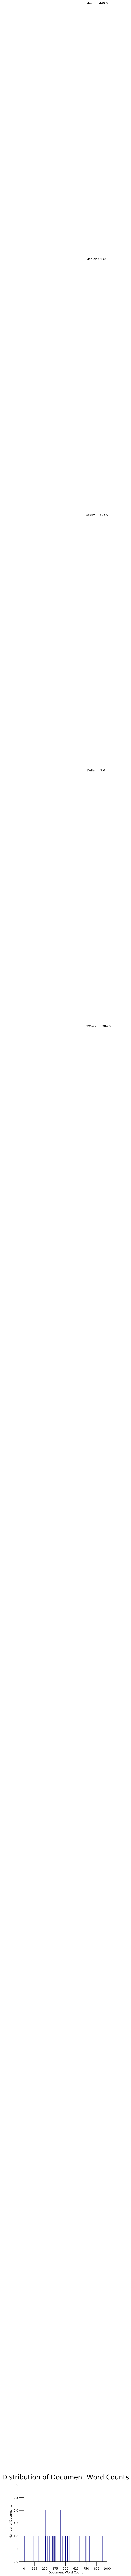

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

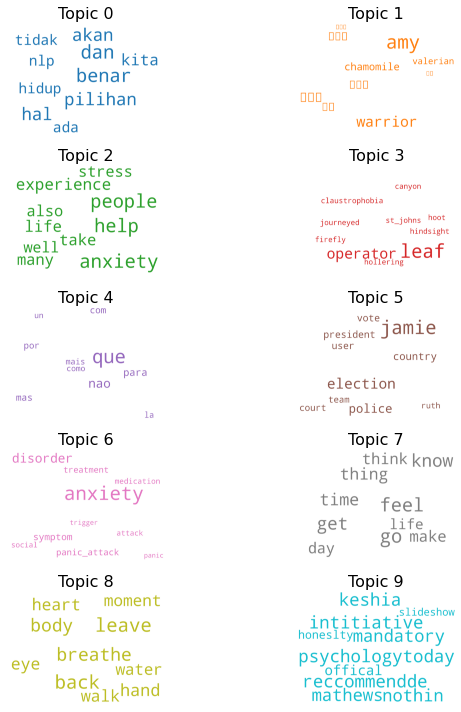

In [46]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [23]:
df_dominant_topic.to_csv("Medium2015.csv")

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=8)

(10, 0.05294340755275628, 0.36617817736168645)

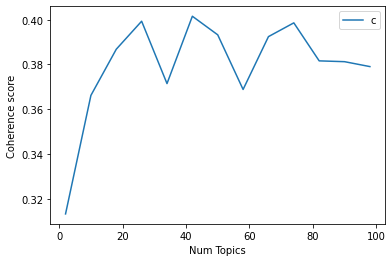

In [38]:
# Show graph
limit=100; start=2; step=8;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)